In [32]:
%load_ext autoreload
%autoreload 2

# Make sure the project root is in Python path
import sys, os
project_root = os.path.abspath("../..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.table import Table
import matplotlib as mpl
from scipy.ndimage import shift
from src.analysis import gaussian_weight, wiener_deconvolution
from scipy.spatial import cKDTree
import pandas as pd
from scipy.signal import fftconvolve
from multiprocessing.dummy import Pool
from tqdm import tqdm

In [34]:
# Set plot parameters
mpl.rcParams['image.cmap'] = 'grey'
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['axes.edgecolor'] = 'none'
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False
mpl.rcParams['ytick.left'] = False
mpl.rcParams['ytick.labelleft'] = False
mpl.rcParams['axes.grid'] = False

In [35]:
location = '/net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData'

In [36]:
aperture_size = 5

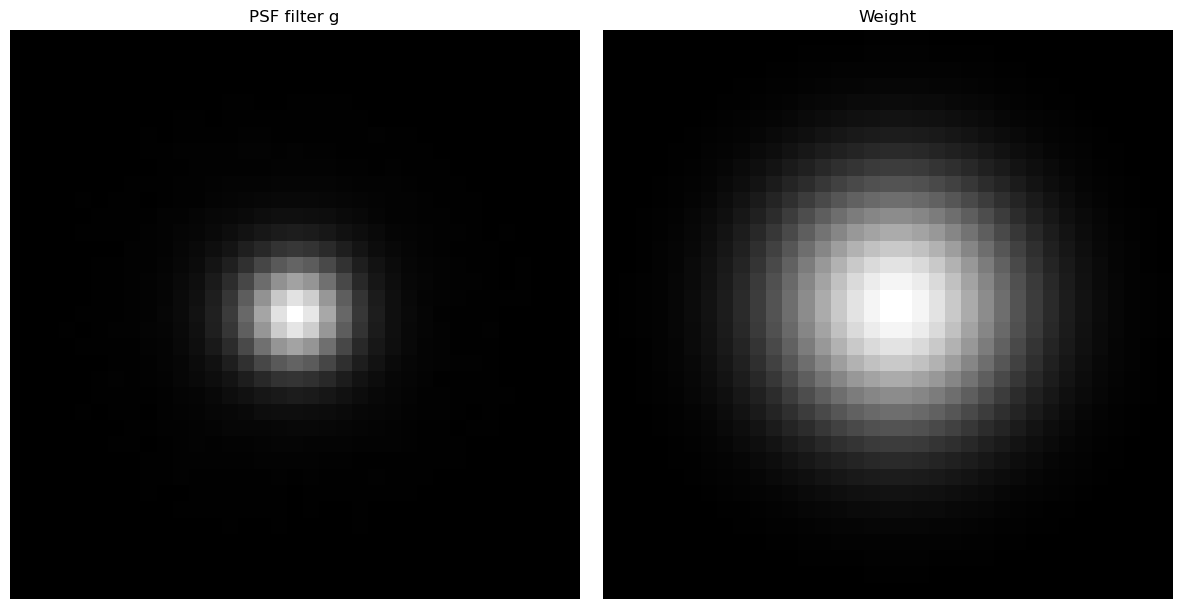

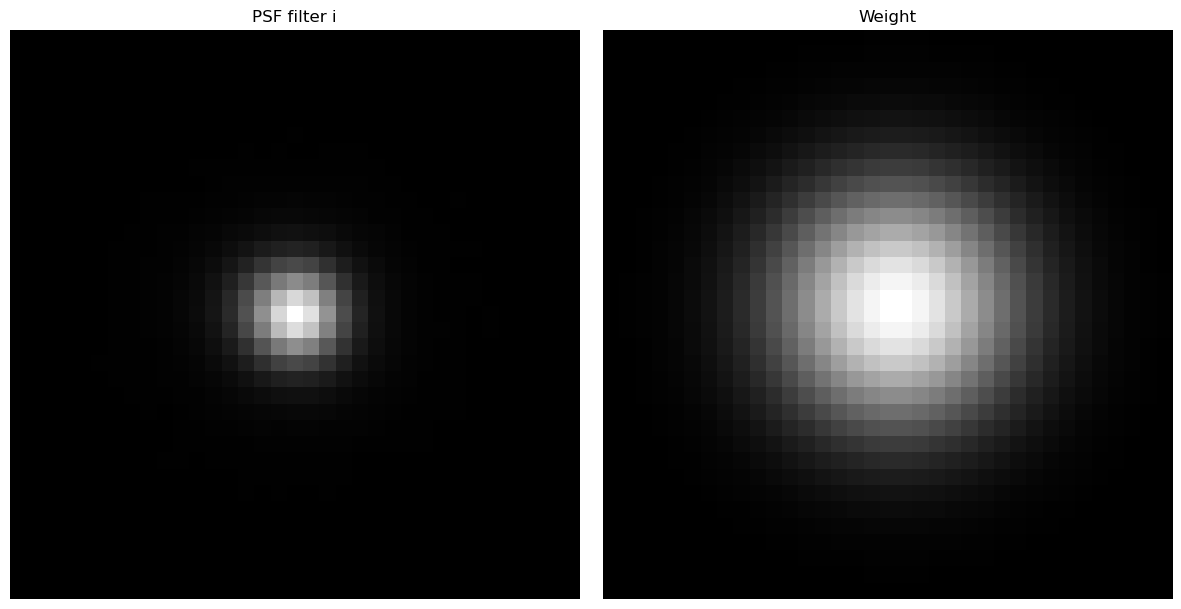

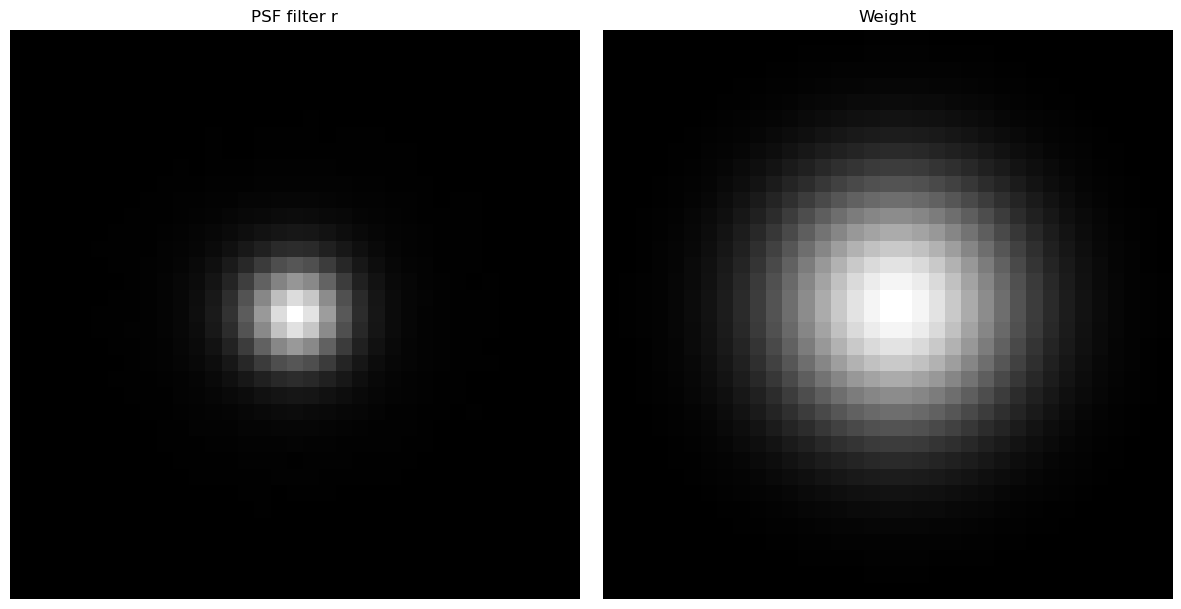

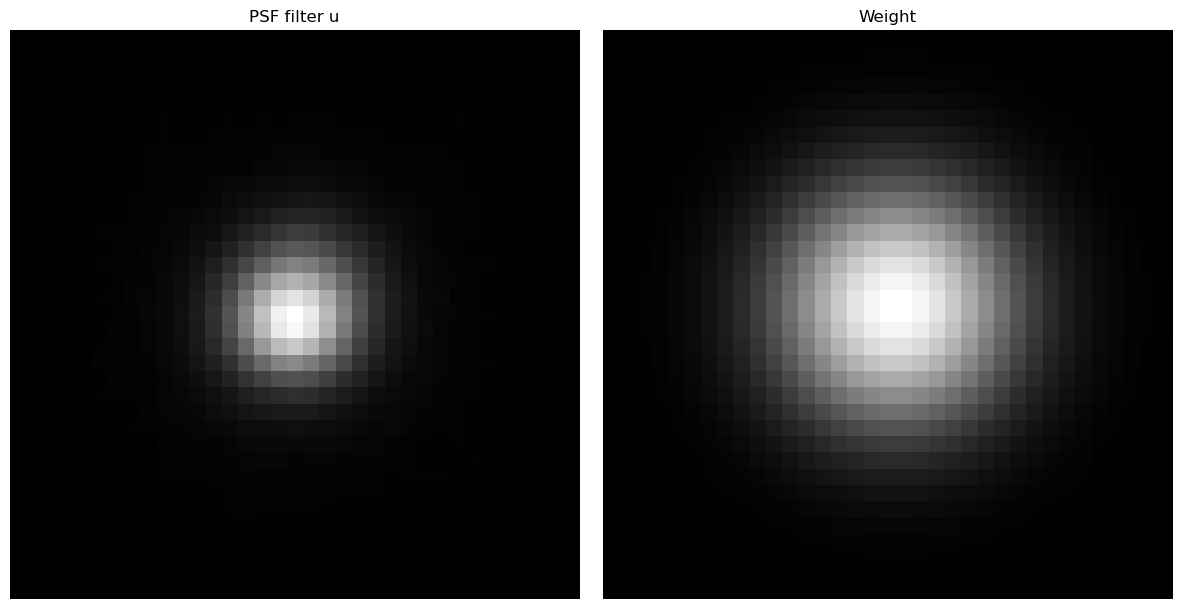

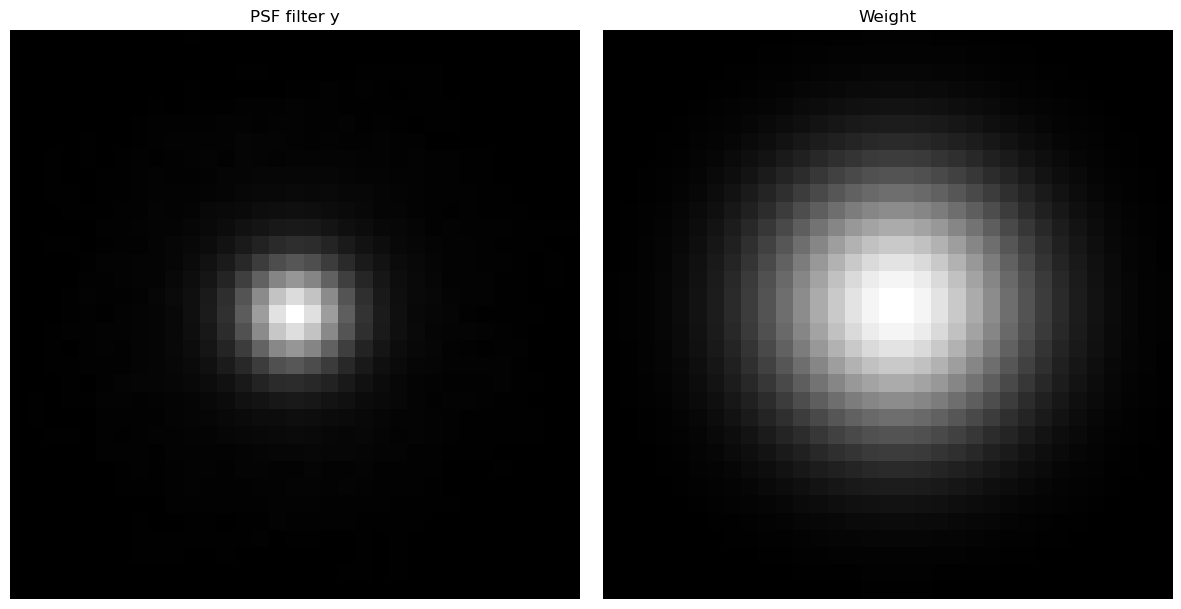

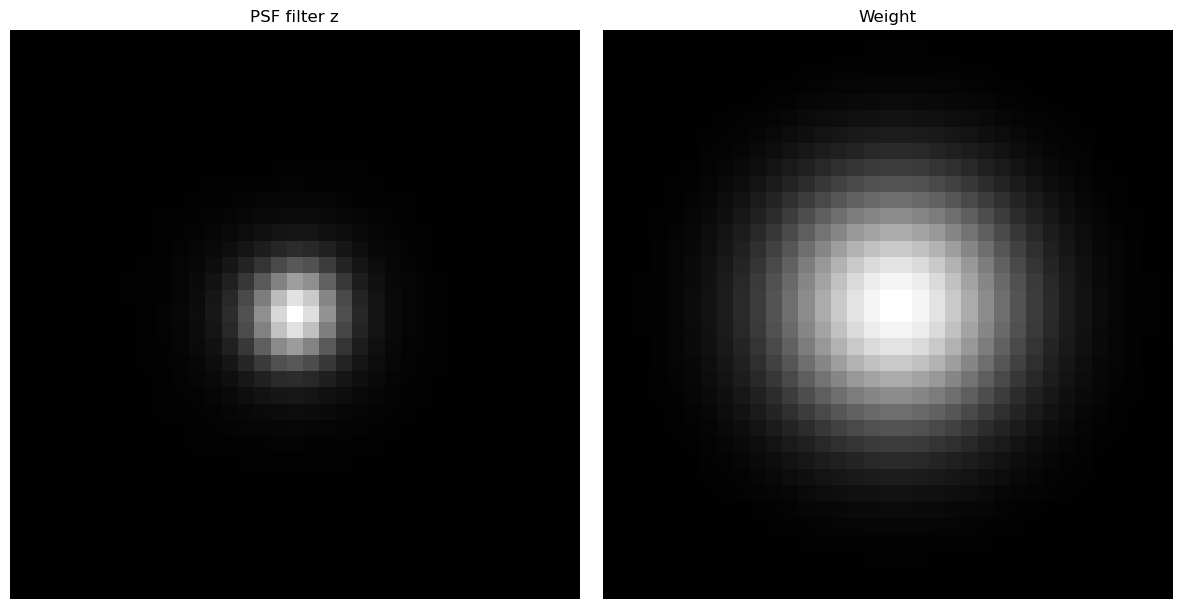

In [37]:
filters = ['g', 'i', 'r', 'u', 'y', 'z']
for fil in filters:
    # Open the FITS file
    with fits.open(f'{location}/53.0_-28.0/{fil}_53.00_-28.00.psf.fits') as hdul:
        psf = hdul[0].data

        # Close the FITS file
        hdul.close()

    weight = gaussian_weight(psf.shape[0], psf.shape[1], psf.shape[0]/2, psf.shape[1]/2, aperture_size, aperture_size)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    im1 = axes[0].imshow(psf)
    axes[0].set_title(f'PSF filter {fil}')

    # Image 2
    im2 = axes[1].imshow(weight)
    axes[1].set_title('Weight')

    plt.tight_layout()
    plt.show()


In [38]:
def find_flux(points):
    xc, yc = points
    return F_map[int(yc), int(xc)]

In [39]:
filters = ['u', 'g', 'r', 'i', 'y', 'z']
sigma = np.zeros_like(filters, dtype=float)
for i, fil in enumerate(filters):
    catalog = Table.read(f'{location}/53.0_-28.0/{fil}.cat', format='ascii')
    
    hdul = fits.open(f'{location}/53.0_-28.0/{fil}_53.00_-28.00.fits')
    image_data = hdul[1].data
    hdul.close()

    weight = gaussian_weight(image_data.shape[0], image_data.shape[1], image_data.shape[0]/2, image_data.shape[1]/2, aperture_size, aperture_size)
    
    hdul = fits.open(f'{location}/53.0_-28.0/{fil}_53.00_-28.00.psf.fits')
    psf = hdul[0].data
    hdul.close()

    x = image_data[image_data<0].flatten()

    n = len(x)
    S = np.sum(x**2)

    # Posterior for tau = sigma^2 is Inv-Gamma(a=n/2, scale=beta=S/2)
    alpha = n / 2.0
    beta = S / 2.0

    sigma[i] = np.sqrt(beta / (alpha + 1))  

    data = {'x': np.array(catalog['X_IMAGE']), 'y': np.array(catalog['Y_IMAGE'])}

    rescaled_weight = wiener_deconvolution(weight, psf, 0)
    sigma[i] *= np.sum(rescaled_weight**2)
    F_map = fftconvolve(image_data, rescaled_weight[::-1, ::-1], mode='same')
    points = [[xc, yc] for (xc, yc) in catalog['X_IMAGE', 'Y_IMAGE']]
    result = np.zeros(len(points))
    for j, point in tqdm(enumerate(points)):
        result[j] = find_flux(point)
    # with Pool() as pool:
    #     result = list(tqdm(pool.imap(shift_and_sum, points), total=len(points)))
    data['flux'] = list(result)
    if fil == 'u':
        u_df = pd.DataFrame(data)
    elif fil == 'g':
        g_df = pd.DataFrame(data)
    elif fil == 'r':
        r_df = pd.DataFrame(data)
    elif fil == 'i':
        i_df = pd.DataFrame(data)
    elif fil == 'y':
        y_df = pd.DataFrame(data)
    elif fil == 'z':
        z_df = pd.DataFrame(data)
    

1227it [00:00, 900509.36it/s]
9084it [00:00, 1543615.34it/s]
9739it [00:00, 1548164.74it/s]
8357it [00:00, 1584476.92it/s]
1591it [00:00, 1515933.14it/s]
5509it [00:00, 1566855.68it/s]


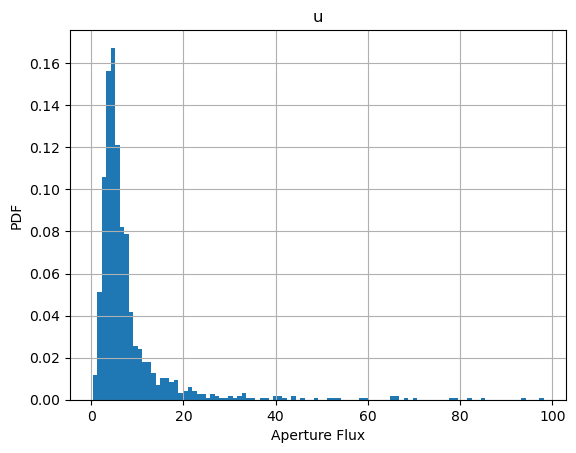

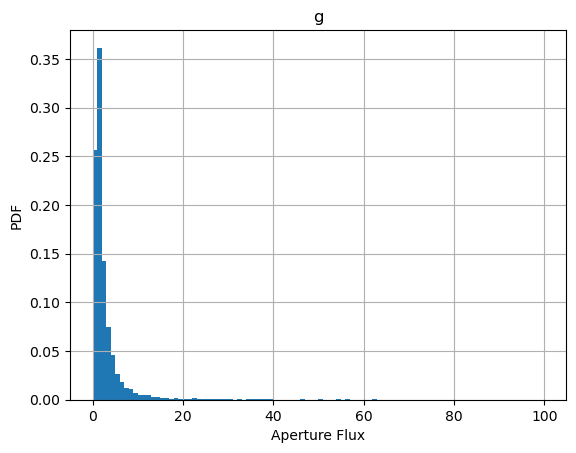

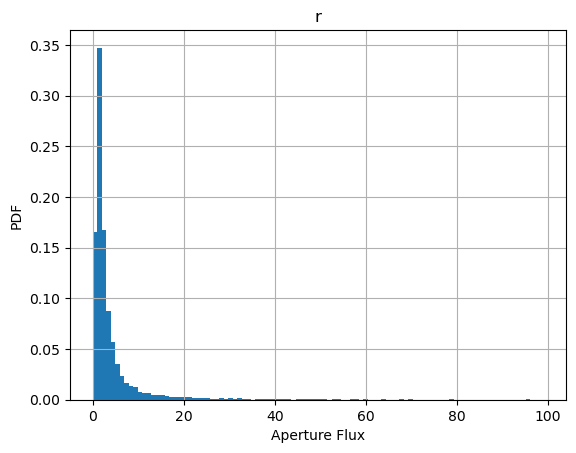

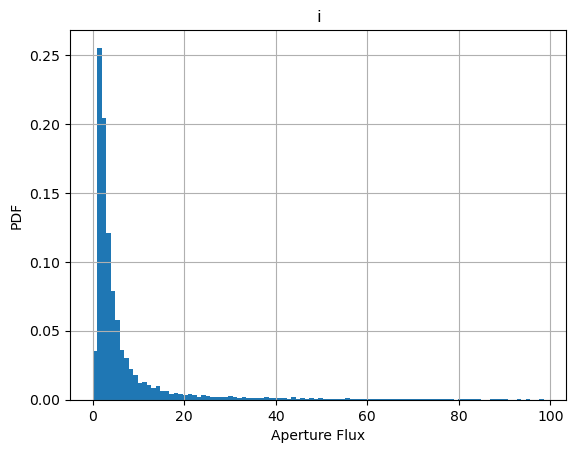

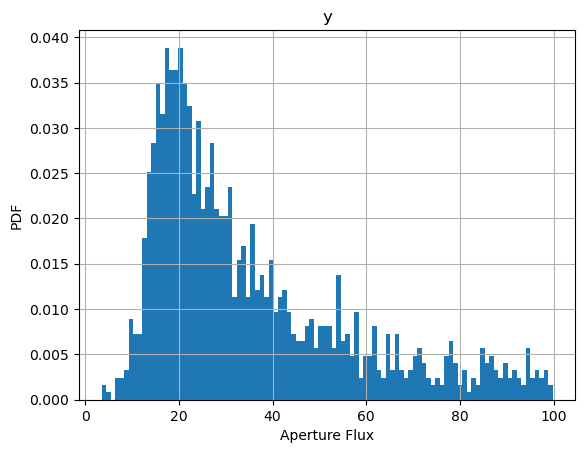

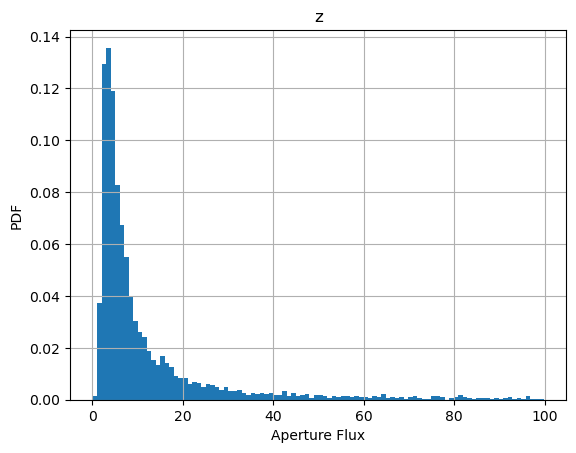

In [40]:
dfs = {
    'u': u_df,
    'g': g_df,
    'r': r_df,
    'i': i_df,
    'y': y_df,
    'z': z_df
}

for key, df in dfs.items():
    with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
    }):
        plt.hist(df['flux'][df['flux']<100], bins=100, density=True)
        plt.xlabel('Aperture Flux')
        plt.ylabel('PDF')
        plt.title(key)
        plt.show()

In [41]:
def align_fluxes_by_reference(dfs, max_dist=2.0):
    """
    Align multiple catalogs by coordinates using the smallest catalog as reference.

    Parameters
    ----------
    dfs : dict
        {filter_name: pandas.DataFrame} each with columns ['x','y','flux']
    max_dist : float
        Maximum distance (pixels) for matching

    Returns
    -------
    bands : list
        Filter names in the same order as columns
    flux_matrix : ndarray
        Shape (N_ref, N_bands), fluxes aligned by reference coordinates
    """
    # Find reference catalog (smallest)
    ref_band = min(dfs, key=lambda k: len(dfs[k]))
    ref_df = dfs[ref_band]
    x_ref = ref_df['x'].values
    y_ref = ref_df['y'].values
    ref_points = np.column_stack((x_ref, y_ref))

    bands = list(dfs.keys())
    flux_list = []

    for band in bands:
        df = dfs[band]
        x = df['x'].values
        y = df['y'].values
        points = np.column_stack((x, y))

        # Build KDTree and query nearest neighbor for each reference point
        tree = cKDTree(points)
        dist, idx = tree.query(ref_points, distance_upper_bound=max_dist)

        # Initialize flux array with NaNs
        flux_aligned = np.full(len(ref_points), np.nan)

        # Fill only valid matches
        valid = idx < len(df)
        flux_aligned[valid] = df['flux'].values[idx[valid]]

        flux_list.append(flux_aligned)

    # Combine into 2D array: rows = galaxies, columns = filters
    flux_matrix = np.column_stack(flux_list)
    return bands, flux_matrix

bands, flux_matrix = align_fluxes_by_reference(dfs, max_dist=2.0)

print("Bands:", bands)
print("Flux matrix shape:", flux_matrix.shape)

Bands: ['u', 'g', 'r', 'i', 'y', 'z']
Flux matrix shape: (1227, 6)


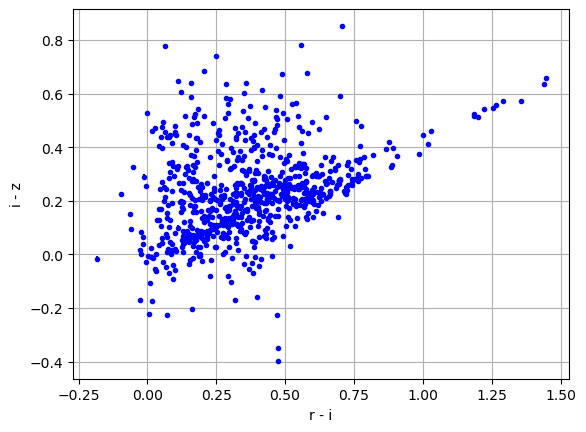

In [44]:
# ['u', 'g', 'r', 'i', 'y', 'z']
filter_1 = 2
filter_2 = 3
filter_3 = 5
with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    for fluxes in flux_matrix:
        x_color = -2.5 * np.log10(fluxes[filter_1]/fluxes[filter_2])
        y_color = -2.5 * np.log10(fluxes[filter_2]/fluxes[filter_3])
        
        xerr = 2.5/np.log(10)*np.sqrt((sigma[filter_1]/fluxes[filter_1])**2+(sigma[filter_2]/fluxes[filter_2])**2)
        yerr = 2.5/np.log(10)*np.sqrt((sigma[filter_2]/fluxes[filter_2])**2+(sigma[filter_3]/fluxes[filter_3])**2)
        
        plt.errorbar(x_color, y_color, xerr=xerr, yerr=yerr, fmt='o', c='b', ms=3)
    # plt.title('Galaxy Color-Color Diagram')
    plt.grid(True)
    plt.xlabel(f'{filters[filter_1]} - {filters[filter_2]}')
    plt.ylabel(f'{filters[filter_2]} - {filters[filter_3]}')
    plt.savefig(f'../../results/figures/CMD{filters[filter_1]}{filters[filter_2]}{filters[filter_3]}.pdf')
    plt.show()